In [1]:
import pandas as pd
import requests
import json
import seaborn
import matplotlib.pyplot as plt

In [2]:
visits = pd.read_csv(r'/Users/mikhailstroganov/Downloads/visits_1k.csv')
regs = pd.read_csv(r'/Users/mikhailstroganov/Downloads/regs_1k.csv')

In [3]:
v = requests.get('https://data-charts-api.hexlet.app/visits?begin=2023-03-01&end=2023-09-01')
vis = v.json()

In [4]:
r = requests.get('https://data-charts-api.hexlet.app/registrations?begin=2023-03-01&end=2023-09-01')
reg = r.json()

In [5]:
df_vis = pd.json_normalize(vis)
df_vis = df_vis.loc[~df_vis['user_agent'].str.contains('bot')]
df_reg = pd.json_normalize(reg)
df_reg

,datetime,email,platform,registration_type,user_id
0,"Wed, 01 Mar 2023 13:21:20 GMT",jlane@example.net,web,google,8dd9b457-f02e-4cff-a66a-d70838849f04
1,"Wed, 01 Mar 2023 01:14:06 GMT",dyerkenneth@example.net,web,yandex,52e2b626-c6fa-4919-a67d-09adb33accdc
2,"Wed, 01 Mar 2023 19:47:32 GMT",kwade@example.com,web,yandex,bab974bd-2176-4497-acb2-4bc61ca93f5c
3,"Wed, 01 Mar 2023 19:19:26 GMT",fisherbrian@example.net,web,email,b517892a-15c0-4320-9f33-e65db1110395
4,"Wed, 01 Mar 2023 02:30:54 GMT",johngomez@example.org,web,google,bd38427f-7120-4c14-a384-889a2335108b
...,...,...,...,...,...
28192,"Thu, 31 Aug 2023 20:51:43 GMT",lunazachary@example.com,ios,email,7065467a-39d2-46c7-9041-ed7fbc8d801f
28193,"Thu, 31 Aug 2023 23:07:32 GMT",amyramirez@example.org,ios,apple,93a04829-5ab4-48b5-abf9-8e267150c512
28194,"Thu, 31 Aug 2023 14:56:54 GMT",webermark@example.org,ios,apple,6ff0e3b5-af42-42ba-ae6e-395051d79360
28195,"Thu, 31 Aug 2023 22:52:45 GMT",alexandermichael@example.com,ios,email,6d8b00e7-4696-43b1-8d79-91f2b7bef9cd


In [6]:
df_vis['datetime'] = pd.to_datetime(df_vis['datetime']).dt.date
df_vis = df_vis.groupby(['datetime', 'platform', 'user_agent', 'visit_id'], as_index=False).agg({'datetime':'max'})
df_vis = df_vis.groupby(['datetime', 'platform'], as_index=False).agg({'visit_id':'count'})

In [7]:
df_reg['datetime'] = pd.to_datetime(df_reg['datetime']).dt.date
df_reg = df_reg.groupby(['datetime', 'platform', 'registration_type'], as_index=False).agg({'user_id':'count'})

In [8]:
mrg = pd.merge(df_vis, df_reg, on=['datetime','platform'], how='inner')
mrg.rename(columns={'datetime':'date_group', 'visit_id':'visits', 'user_id':'registrations'}, inplace=True)
mrg['conversion'] = mrg['registrations']/mrg['visits']
mrg.sort_values(by='date_group', inplace=True)
mrg

,date_group,platform,visits,registration_type,registrations,conversion
0,2023-03-01,android,264,email,113,0.428030
1,2023-03-01,android,264,google,105,0.397727
2,2023-03-01,ios,78,apple,28,0.358974
3,2023-03-01,ios,78,email,39,0.500000
4,2023-03-01,web,1977,apple,20,0.010116
...,...,...,...,...,...,...
1424,2023-08-31,ios,16,apple,6,0.375000
1425,2023-08-31,ios,16,email,7,0.437500
1426,2023-08-31,web,688,apple,4,0.005814
1427,2023-08-31,web,688,email,10,0.014535


In [9]:
ads = pd.read_csv('/Users/mikhailstroganov/Downloads/ads.csv')
ads['date'] = pd.to_datetime(ads['date']).dt.date
ads

,date,utm_source,utm_medium,utm_campaign,cost
0,2023-03-01,google,cpc,virtual_reality_workshop,238
1,2023-03-02,google,cpc,virtual_reality_workshop,164
2,2023-03-03,google,cpc,virtual_reality_workshop,240
3,2023-03-04,google,cpc,virtual_reality_workshop,167
4,2023-03-05,google,cpc,virtual_reality_workshop,268
...,...,...,...,...,...
175,2023-09-05,yandex,cpc,cybersecurity_special,221
176,2023-09-06,yandex,cpc,cybersecurity_special,124
177,2023-09-07,yandex,cpc,cybersecurity_special,211
178,2023-09-08,yandex,cpc,cybersecurity_special,195


In [10]:
to_mrg = mrg.groupby(by='date_group', as_index=False).agg({'visits':'sum','registrations':'sum'})
to_mrg_2 = ads.groupby(by=['date','utm_campaign'], as_index=False).agg({'cost':'sum'})
fin = pd.merge(to_mrg, to_mrg_2, left_on='date_group', right_on='date', how='left')
fin.drop('date', axis=1, inplace=True)
fin.fillna('none', inplace=True)
fin.sort_values(by='date_group', inplace=True)
fin.to_json('ads.json')

In [127]:
fin

,date_group,visits,registrations,utm_campaign,cost
0,2023-03-01,8592,363,virtual_reality_workshop,238.0
1,2023-03-02,8062,219,virtual_reality_workshop,164.0
2,2023-03-03,13948,338,virtual_reality_workshop,240.0
3,2023-03-04,16268,278,virtual_reality_workshop,167.0
4,2023-03-05,15210,362,virtual_reality_workshop,268.0
...,...,...,...,...,...
179,2023-08-27,5126,130,cybersecurity_special,290.0
180,2023-08-28,4468,88,cybersecurity_special,250.0
181,2023-08-29,5920,132,cybersecurity_special,135.0
182,2023-08-30,3270,90,cybersecurity_special,130.0


In [ ]:
Итоговые визиты

<Axes: xlabel='date_group', ylabel='visits'>

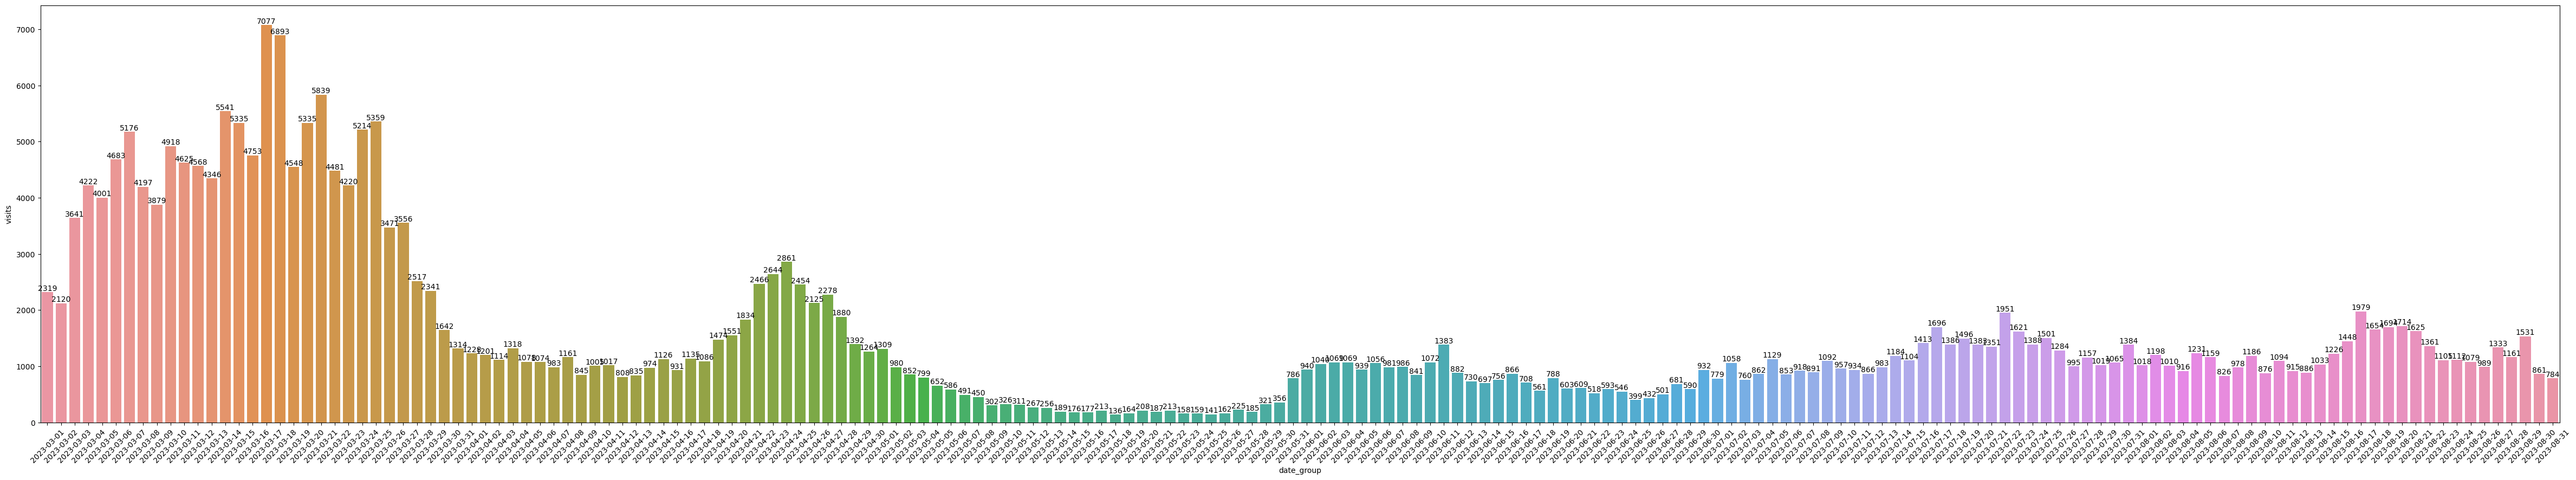

In [53]:
fig, ax = plt.subplots(figsize=(60, 10))
dat = seaborn.barplot(data=mrg.groupby(by='date_group', as_index=False).agg({'visits':'sum'}), x='date_group' , y='visits', ax=ax)
dat.set_xticklabels(dat.get_xticklabels(), rotation=45)
dat.bar_label(ax.containers[0], fontsize=10);
dat

In [ ]:
Итоговые визиты с разбивкой по платформам: web, android, ios, bot

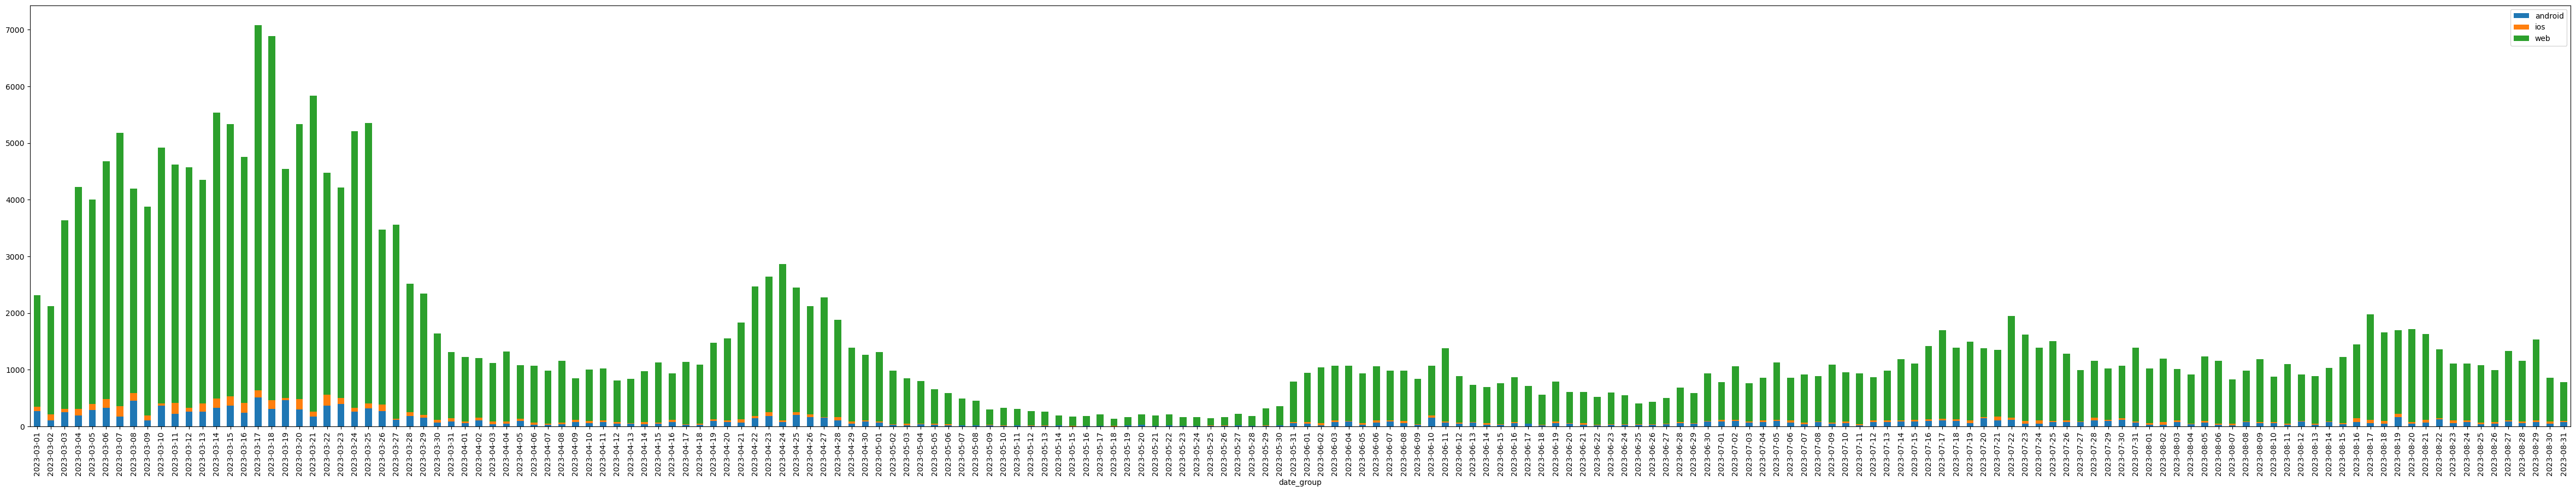

In [51]:
fig2, ax2 = plt.subplots(figsize=(60, 10))
dat2 = mrg.groupby(by=['date_group','platform']).agg({'visits':'sum'}).unstack().plot(kind='bar', stacked=True, ax=ax2)
ax2.legend(['android', 'ios', 'web'])

In [ ]:
Итоговые регистрации

<Axes: xlabel='date_group', ylabel='registrations'>

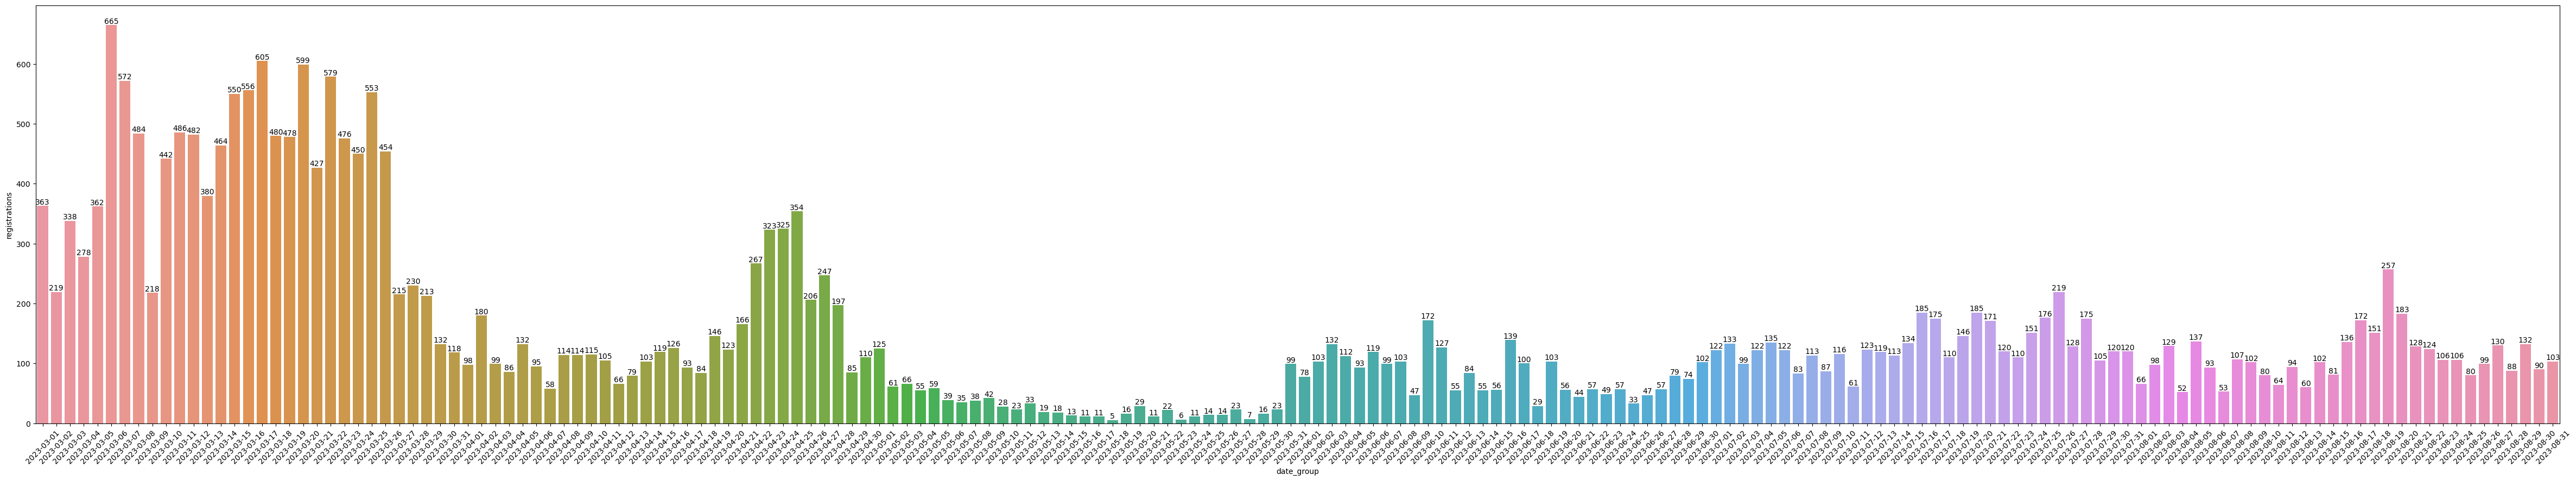

In [55]:
fig3, ax3 = plt.subplots(figsize=(60, 10))
dat3 = seaborn.barplot(data=mrg.groupby(by='date_group', as_index=False).agg({'registrations':'sum'}), x='date_group' , y='registrations', ax=ax3)
dat3.set_xticklabels(dat.get_xticklabels(), rotation=45)
dat3.bar_label(ax3.containers[0], fontsize=10);
dat3

In [ ]:
Итоговые регистрации с разбивкой по платформе: web, android, ios

<Axes: xlabel='date_group'>

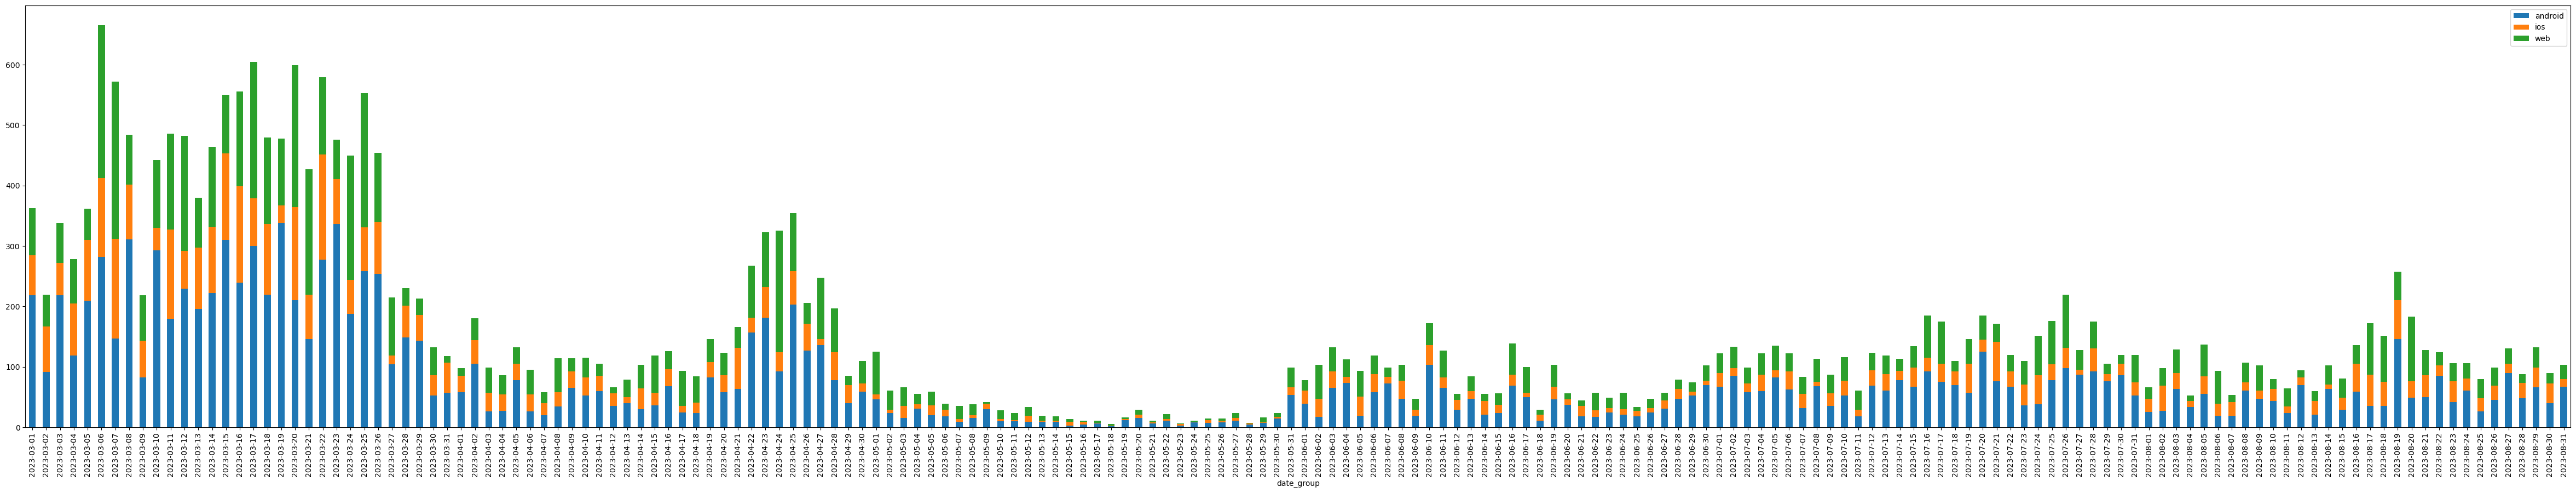

In [57]:
fig4, ax4 = plt.subplots(figsize=(60, 10))
dat4 = mrg.groupby(by=['date_group','platform']).agg({'registrations':'sum'}).unstack().plot(kind='bar', stacked=True, ax=ax4)
ax4.legend(['android', 'ios', 'web'])
dat4

In [ ]:
Итоговые регистрации с разбивкой по типу регистрации: email, google, apple, yandex

<Axes: xlabel='date_group'>

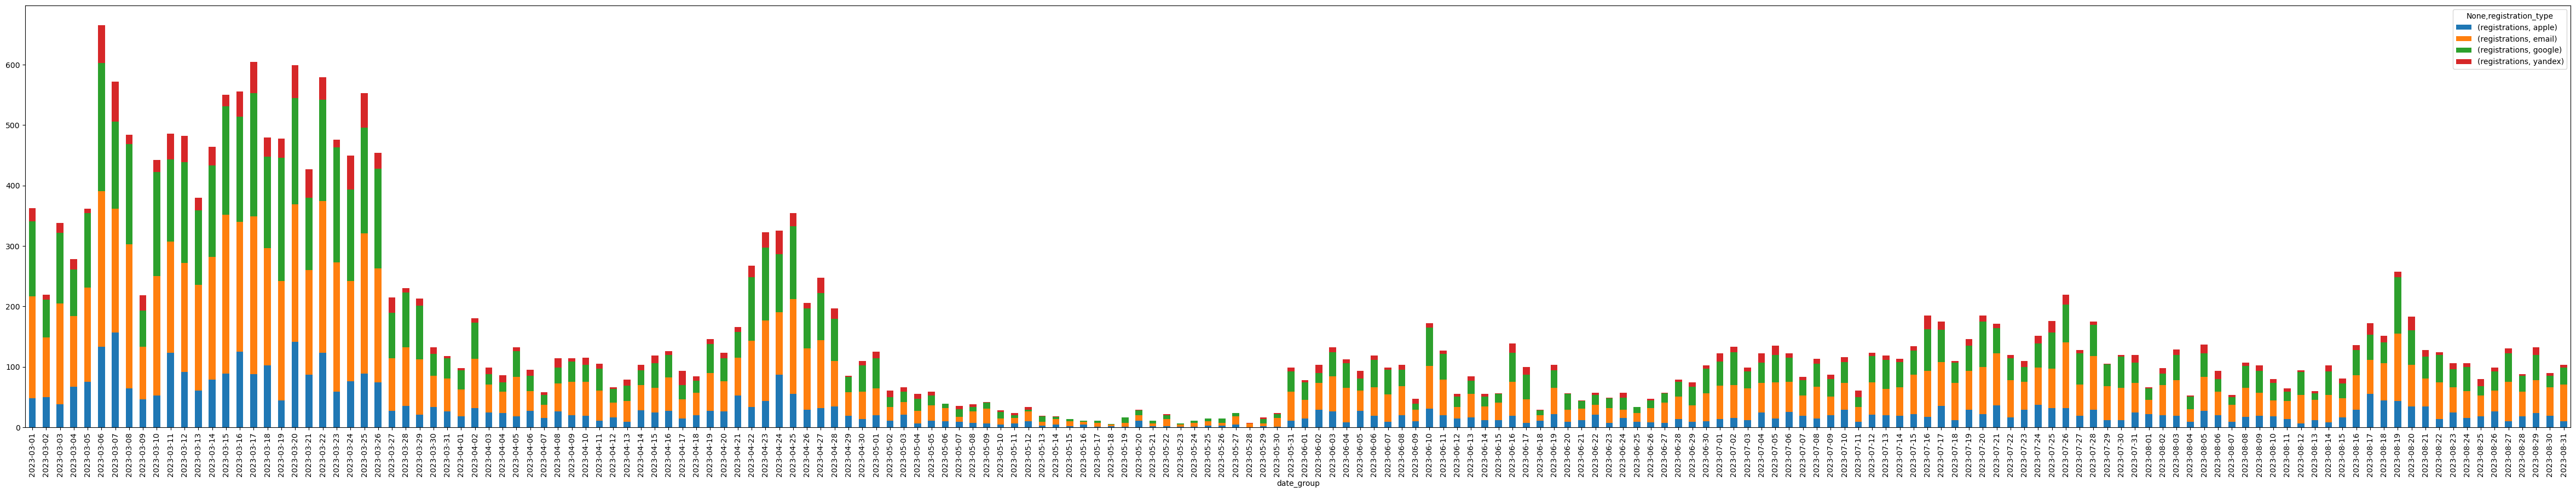

In [67]:
fig5, ax5 = plt.subplots(figsize=(60, 10))
dat5 = mrg.groupby(by=['date_group','registration_type']).agg({'registrations':'sum'}).unstack().plot(kind='bar', stacked=True, ax=ax5)
ax5.legend(['apple', 'email', 'google', 'yandex'])
dat5

In [ ]:
Конверсия по каждой платформе

In [ ]:
Средняя конверсия

<Axes: xlabel='date_group', ylabel='conversion'>

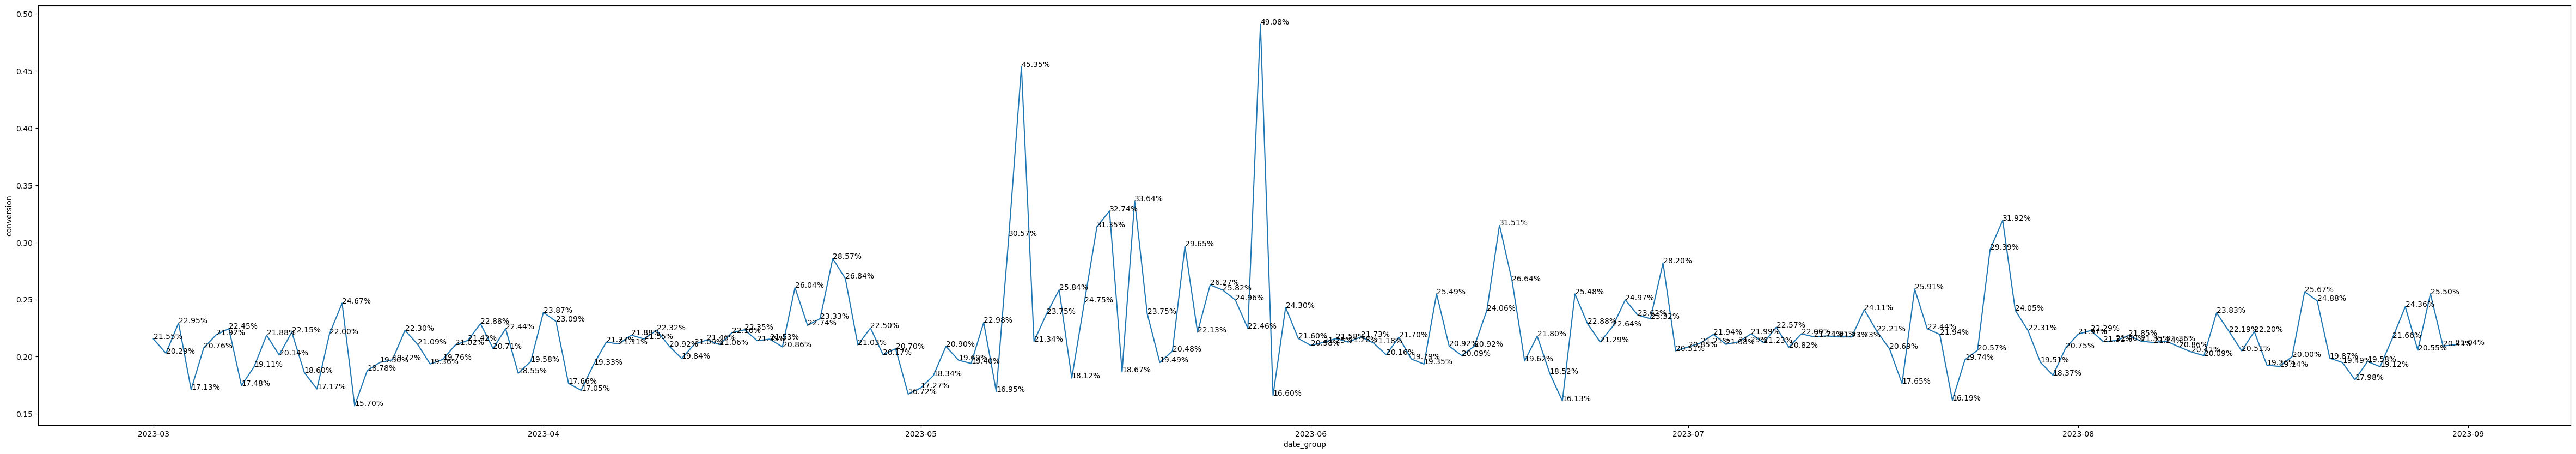

In [76]:
fig6, ax6 = plt.subplots(figsize=(60, 10))
dat6 = seaborn.lineplot(data=mrg.groupby(by='date_group', as_index=False).agg({'conversion':'mean'}), x='date_group' , y='conversion', ax=ax6)

for x, y in zip(mrg.groupby(by='date_group', as_index=False).agg({'conversion':'mean'})['date_group'], mrg.groupby(by='date_group', as_index=False).agg({'conversion':'mean'})['conversion']):
    plt.text(x = x, y = y, s = '{:.2f}%'.format(y*100))
    
    
dat6    
    
    

In [ ]:
Конверсия по каждой платформе

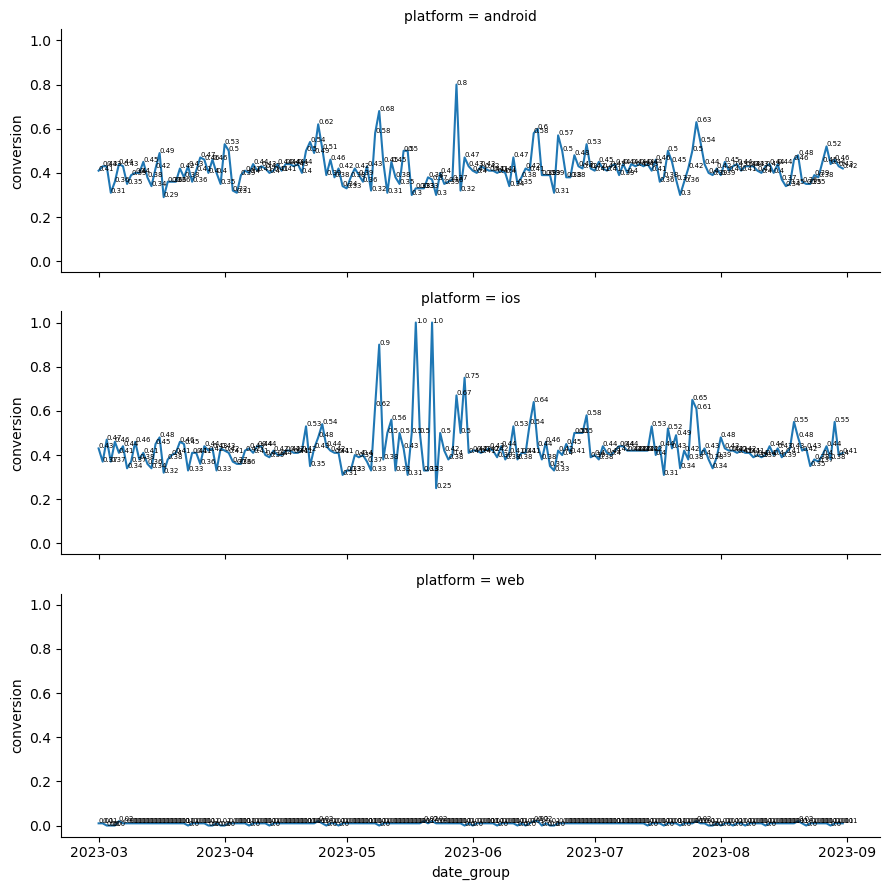

In [107]:
inf = mrg.groupby(by=['date_group','platform'], as_index=False).agg({'conversion':'mean'})
inf['conversion'] = round(inf['conversion'],2)
dat7 = seaborn.FacetGrid(inf, col='platform', col_wrap=1, aspect=3)

dat7.map(seaborn.lineplot, 'date_group', 'conversion')

def annotate_points(x,y,t, **kwargs):
    ax = plt.gca()
    data = kwargs.pop('data')
    for i,row in data.iterrows():
        ax.annotate(row[t], xy=(row[x],row[y]), fontsize=5)
    
dat7.map_dataframe(annotate_points, "date_group", "conversion", 'conversion')



In [ ]:
Стоимости реклам

In [133]:
fin.groupby(by='utm_campaign', as_index=False).agg({'date_group':['min','max']})

utm_campaign  date_group            
                                    min         max
0     cybersecurity_special  2023-07-29  2023-08-31
1     game_dev_crash_course  2023-04-09  2023-05-07
2                      none  2023-04-06  2023-07-28
3          tech_career_fair  2023-06-20  2023-07-25
4  virtual_reality_workshop  2023-03-01  2023-04-05
5   web_dev_workshop_series  2023-05-09  2023-06-13

<Axes: xlabel='date', ylabel='cost'>

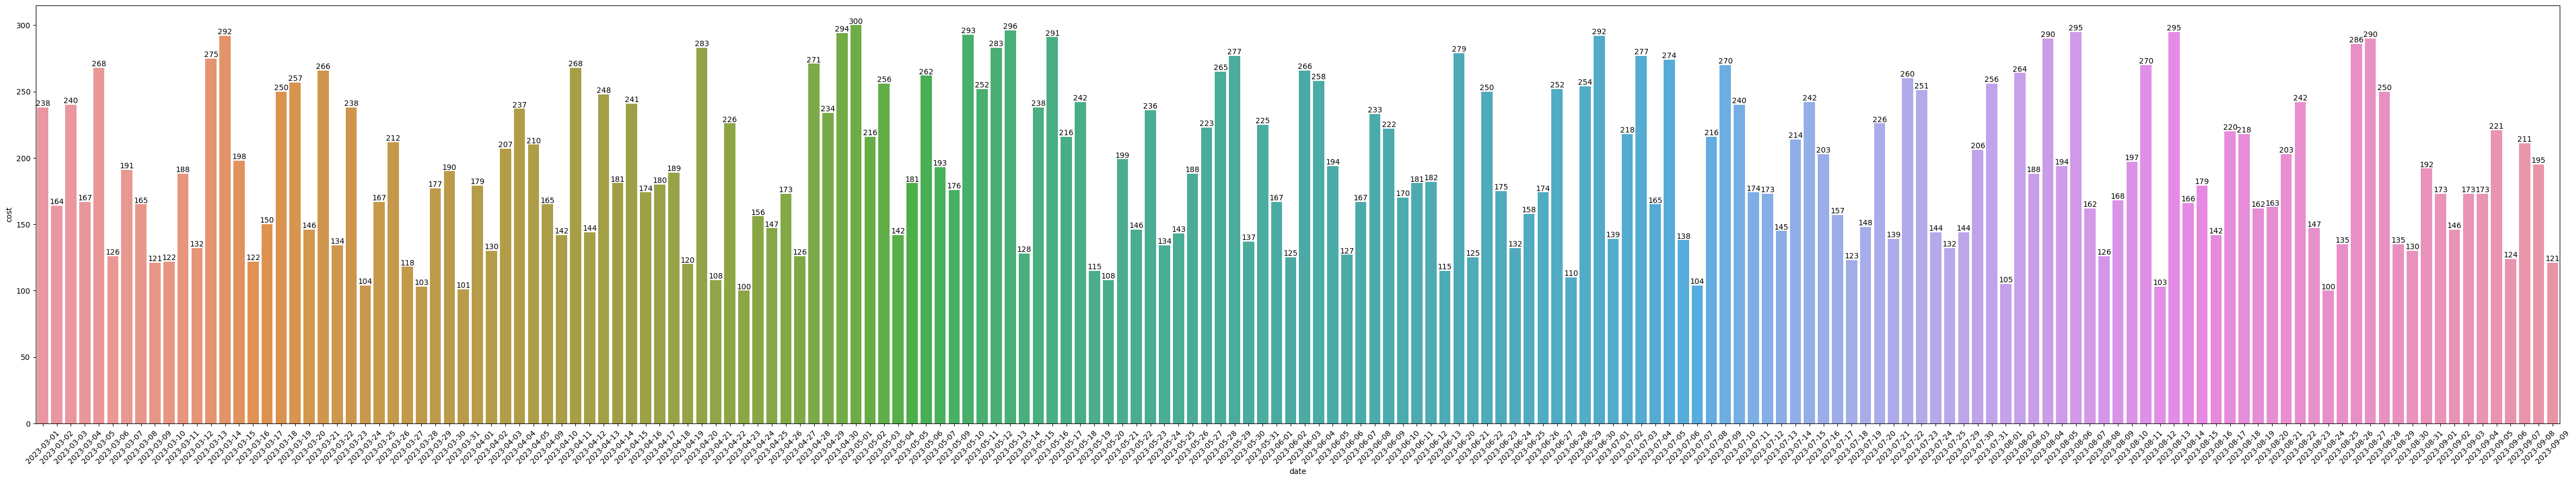

In [111]:
fig8, ax8 = plt.subplots(figsize=(60, 10))
dat8 = seaborn.barplot(data=ads.groupby(by='date', as_index=False).agg({'cost':'sum'}), x='date' , y='cost', ax=ax8)
dat8.set_xticklabels(dat8.get_xticklabels(), rotation=45)
dat8.bar_label(ax8.containers[0], fontsize=10);
dat8

In [ ]:
Визиты за весь период с цветовым выделением рекламной кампании

<Axes: xlabel='date_group', ylabel='visits'>

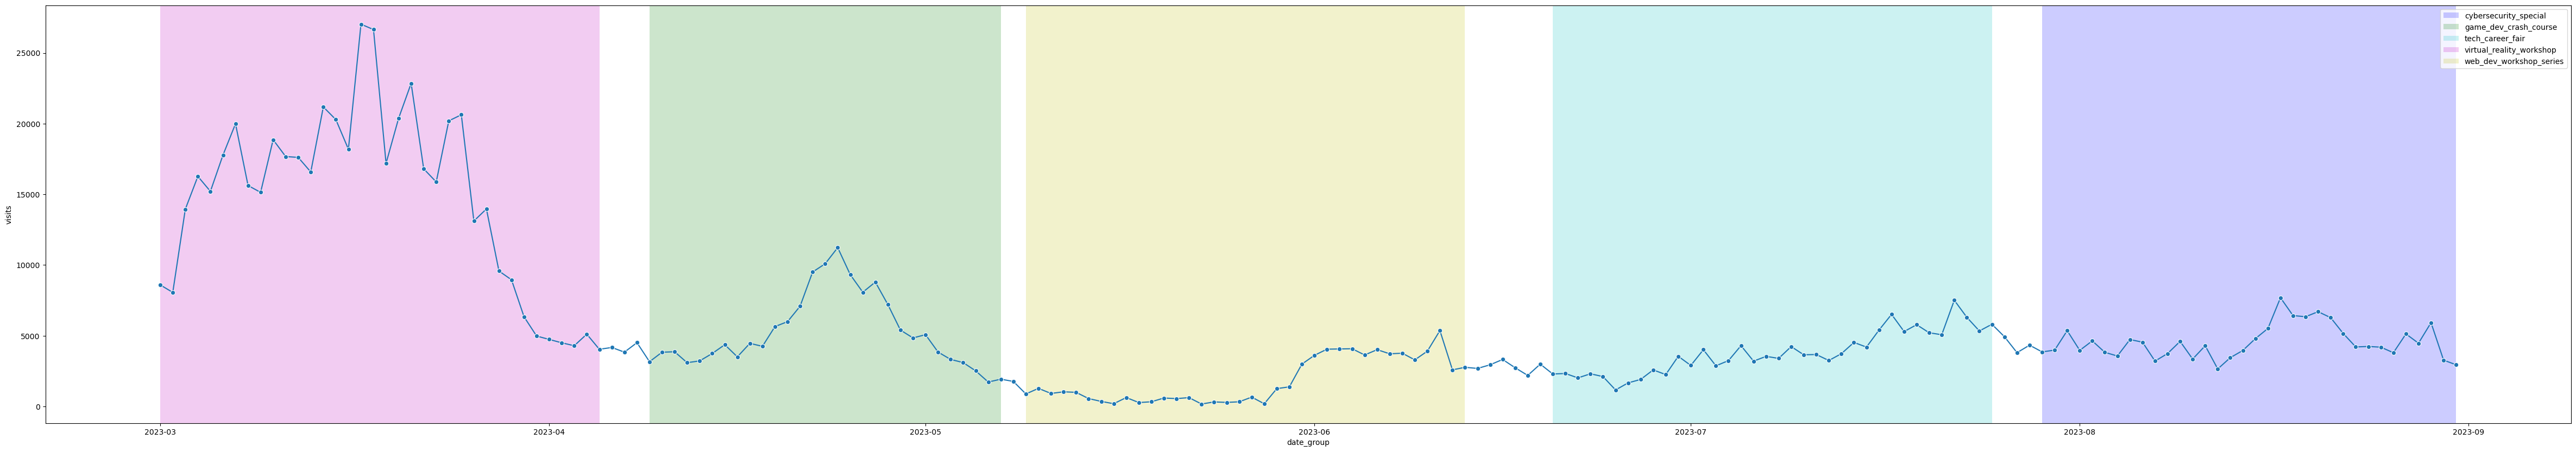

In [14]:
fig, ax = plt.subplots(figsize=(60, 10))
inf = fin.groupby(by='utm_campaign', as_index=False).agg({'date_group':['min','max']})
dat = seaborn.lineplot(data=fin.groupby(by='date_group', as_index=False).agg({'visits':'sum'}), 
                       x='date_group' , y='visits', ax=ax, marker='o')

colors=['b', 'g', 'r', 'c', 'm', 'y']
for index, i in inf.iterrows():
    if i['utm_campaign'].iloc[0] == 'none':
        continue
    ax.axvspan(xmin=i['date_group']['min'], xmax=i['date_group']['max'], alpha=0.2, facecolor =colors[index], 
               label=i['utm_campaign'].iloc[0])
plt.legend(loc='upper right')
dat

In [ ]:
Регистрации за весь период с цветовым выделением рекламной кампании

<Axes: xlabel='date_group', ylabel='registrations'>

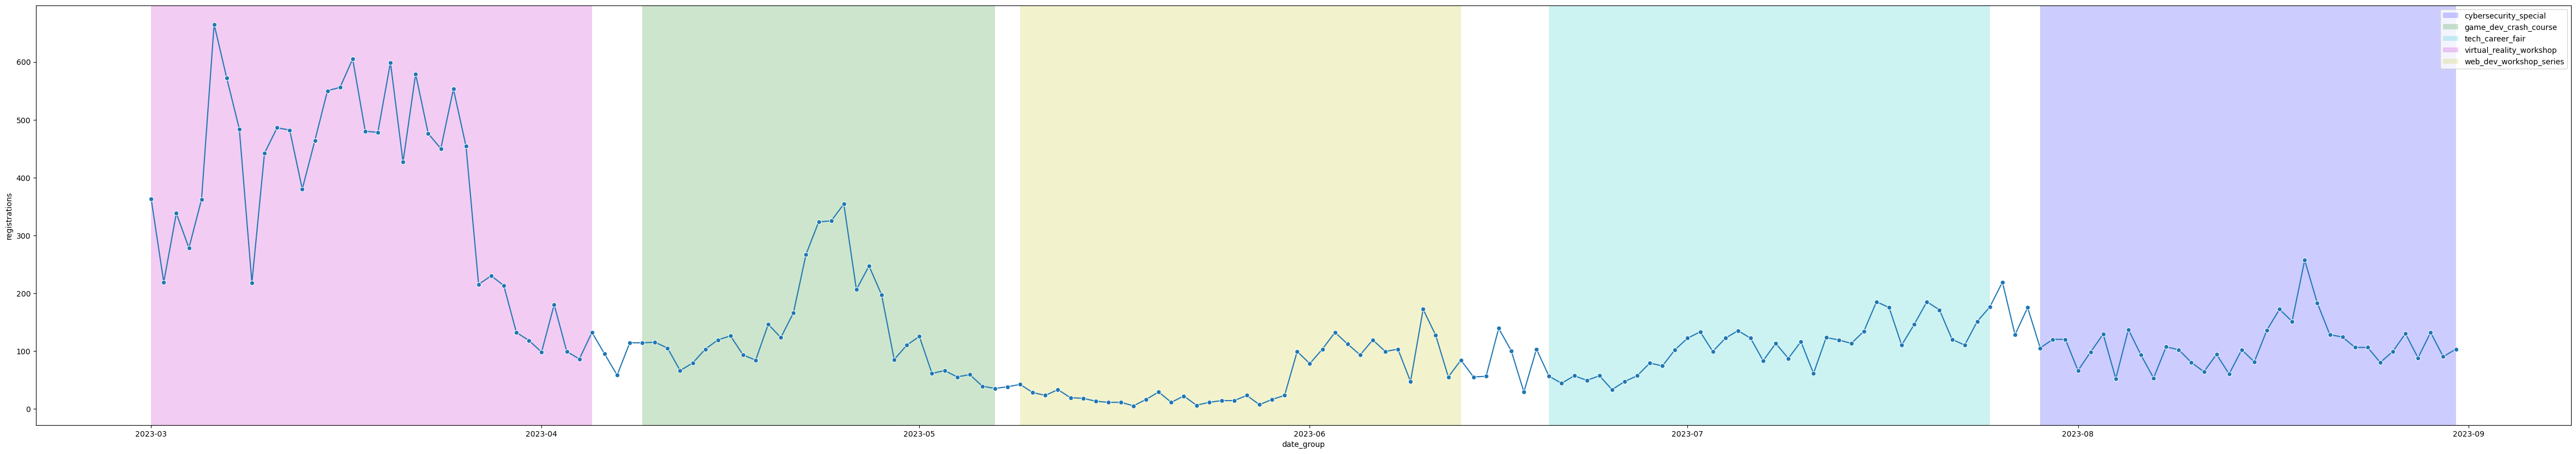

In [15]:
fig, ax = plt.subplots(figsize=(60, 10))
inf = fin.groupby(by='utm_campaign', as_index=False).agg({'date_group':['min','max']})
dat = seaborn.lineplot(data=fin.groupby(by='date_group', as_index=False).agg({'registrations':'sum'}), 
                       x='date_group' , y='registrations', ax=ax, marker='o')

colors=['b', 'g', 'r', 'c', 'm', 'y']
for index, i in inf.iterrows():
    if i['utm_campaign'].iloc[0] == 'none':
        continue
    ax.axvspan(xmin=i['date_group']['min'], xmax=i['date_group']['max'], alpha=0.2, facecolor =colors[index], 
               label=i['utm_campaign'].iloc[0])
plt.legend(loc='upper right')
dat